## Better Way Reform Plan

In [1]:
import sys
sys.path.append("../../")
from taxcalc import *
import pandas as pd
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.transforms import BlendedGenericTransform
%matplotlib inline

### Baseline

In [2]:
policy_xx = Policy()
behavior_xx = Behavior()
records_xx = Records("../../puf.csv")

### The full reform plan

In [3]:
# Set 10% and 15% brackets to 12%
# Set 25% and 28% brackets to 25%
# Set 33%, 35% and 39.6% brackets to 33%
# Repeal Alternative minumum tax
# Standard deduction 12K for single/separate, 24K for married, 18K for single with child(Head of HH)
#    Should we eliminate the additional standard deduction for the aged and blind?
# Personal exemption '_II_credit' set to zero
# Child tax credit phaseout for married couples increased to $150K
# Eliminated all itemized deductions except mortgage and charity
# Excluded half of interest income from final taxable interest income to match rates on cap gains/dividends
# Cap gains & dividend income changed
#    Second cap gains threshold moved to same as fourth income tax bracket
#    Rates adjusted to 6%, 12.5% and 16.5%
# Eliminated NIIT

# Didn't implement business pass-thru rate to 25%--try 31.3% top rate instead
# Didn't implement change from depreciation to expensing
# Didn't deal with eliminating net interest expense deductions for businesses
# Didn't eliminate Section 199
# Didn't implement changes to net operating losses
# Didn't repeal estate and gift taxes



policy_y1 = Policy()
behavior_y1 = Behavior()
records_y1 = Records("../../puf.csv")
reform_y1 = {
    2017: {
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.33],
        '_II_rt6': [0.33],
        '_II_rt7': [0.33],
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 1050]],
        '_STD_Aged': [[0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]],
        '_II_em': [0,0,0,0],
        '_CTC_ps': [[75000, 150000, 55000, 75000, 75000, 55000]],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0],
        '_ALD_Interest_ec': [0.5],        
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165],
        '_NIIT_trt': [0.0]
    }
}

policy_y1.implement_reform(reform_y1)

behavior_traits = {2017: {'_BE_inc': [0.0], '_BE_sub': [0.3], '_BE_cg': [2.7]}}
#For substitution effect, Saez, Slemrod and Giertz put it between 0.12 and 0.4

# Static calculators

In [4]:
calc_xx = Calculator(policy_xx, records_xx, behavior_xx)
for i in range(4):
    calc_xx.increment_year()
assert calc_xx.current_year == 2017
calc_y1 = Calculator(policy_y1, records_y1, behavior_y1)
for i in range(4):
    calc_y1.increment_year()
assert calc_y1.current_year == 2017

You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.


In [5]:
print calc_xx.current_year
print calc_y1.current_year

2017
2017


In [6]:
calc_xx.calc_all()
calc_y1.calc_all()

### Static revenue effect for 2017

In [7]:
calc_xx_combined = (calc_xx.records._combined * calc_xx.records.s006)
calc_y1_combined = (calc_y1.records._combined * calc_y1.records.s006)

diff_static_y1_xx = (calc_y1_combined - calc_xx_combined).sum() / 10**9
print "Static net revenue change: " + str(diff_static_y1_xx) + " billion dollars"

Static net revenue change: -39.7477689987 billion dollars


### Static calculator that iterates across years

In [8]:
static_path = [0] * 10

def static_path_change(calcx, calcy):
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1.calc_all()
        calc2.calc_all()
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        static_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
        
static_path_change(calc_xx, calc_y1)
print static_path

[-40.062041432737864, -37.90922793168227, -34.78563397454627, -32.56678771355769, -31.100856443990445, -29.98766059110511, -29.364242105339486, -29.17222927266734, -29.38150472513042, -30.08064586883587]


In [9]:
for i in range(10):
    print static_path[i]
#These are the revenue impacts for the years 2017-2026

-40.0620414327
-37.9092279317
-34.7856339745
-32.5667877136
-31.100856444
-29.9876605911
-29.3642421053
-29.1722292727
-29.3815047251
-30.0806458688


## Behavioral calculators

In [8]:
# Behavioral factors
calc_xx.behavior.update_behavior(behavior_traits)
calc_y1.behavior.update_behavior(behavior_traits)

calc_y1_beh = Behavior.response(calc_xx, calc_y1)
print "Done"



Done


In [9]:
print calc_y1_beh.current_year

2017


### Revenue effect with behavioral changes for 2017

In [10]:
calc_y1_beh_combined = (calc_y1_beh.records._combined * calc_y1_beh.records.s006)
diff_Beh_y1_xx = (calc_y1_beh_combined - calc_xx_combined).sum() / 10**9
print "With behavioral effects, net revenue change: " + str(diff_Beh_y1_xx) + " billion dollars"

With behavioral effects, net revenue change: 8.4892997316 billion dollars


### Behavioral calculator that iterates across years

In [13]:
behavioral_path = [0] * 10

def behavioral_path_change(calcx, calcy):
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        behavioral_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
            calc1.calc_all()
            calc2.behavior.response(calc1, calc2)
        print calc2.current_year
            
        
behavioral_path_change(calc_xx, calc_y1_beh)
print behavioral_path

2018
2019
2020
2021
2022
2023
2024
2025
2026
2026
[8.170808440733415, 11.941792571622395, 16.444126401237543, 20.470433808329567, 24.145655383706096, 27.663559760560894, 30.854037037307577, 33.76584291614264, 36.43239698209204, 38.63250956432881]


In [14]:
for i in range(10):
    print behavioral_path[i]
#Dynamic revenue impacts for years 2017-2026

8.17080844073
11.9417925716
16.4441264012
20.4704338083
24.1456553837
27.6635597606
30.8540370373
33.7658429161
36.4323969821
38.6325095643


## Diagnostics and analysis of reform plan

### Static diagnostics

In [16]:
numIded = calc_y1.records.s006[(calc_y1.records.c04470 > 0.) * (calc_y1.records.c00100 > 0.)].sum()
numStd = calc_y1.records.s006[(calc_y1.records._standard > 0.) * (calc_y1.records.c00100 > 0.)].sum()
print str(round(numIded / 1000) / 1000.0) + " million taxpayers using itemized deductions under reform"
print str(round(numStd / 1000) / 1000.0) + " million taxpayers using the standard deduction under reform"

numIdedxx = calc_xx.records.s006[(calc_xx.records.c04470 > 0.) * (calc_xx.records.c00100 > 0.)].sum()
numStdxx = calc_xx.records.s006[(calc_xx.records._standard > 0.) * (calc_xx.records.c00100 > 0.)].sum()
print str(round(numIdedxx / 1000) / 1000.0) + " million taxpayers using itemized deductions under baseline"
print str(round(numStdxx / 1000) / 1000.0) + " million taxpayers using the standard deduction under baseline"

avgmtr_xx_wage = (calc_xx.mtr('e00200p')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_wage = (calc_y1.mtr('e00200p')[2] * calc_y1.records.s006).sum() / calc_y1.records.s006.sum()
avgmtr_xx_cg = (calc_xx.mtr('p23250')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_cg = (calc_y1.mtr('p23250')[2] * calc_y1.records.s006).sum() / calc_y1.records.s006.sum()
print "\n" + "The average MTR on wage/salary income goes from " + str(avgmtr_xx_wage) + " to " + str(avgmtr_y1_wage)
print "The average MTR on long-term capital gains goes from " + str(avgmtr_xx_cg) + " to " + str(avgmtr_y1_cg)


8.545 million taxpayers using itemized deductions under reform
150.351 million taxpayers using the standard deduction under reform
45.459 million taxpayers using itemized deductions under baseline
113.608 million taxpayers using the standard deduction under baseline

The average MTR on wage/salary income goes from 0.246084566564 to 0.240542477525
The average MTR on long-term capital gains goes from 0.0554948996054 to 0.0724112525535


In [18]:
wavgmtr_xx_wage = ((calc_xx.mtr('e00200p')[2] * calc_xx.records.e00200 * calc_xx.records.s006).sum() / 
                   (calc_xx.records.e00200 * calc_xx.records.s006).sum())
wavgmtr_y1_wage = ((calc_y1.mtr('e00200p')[2] * calc_y1.records.e00200 * calc_y1.records.s006).sum() / 
                       (calc_y1.records.e00200 * calc_y1.records.s006).sum())
print ("The weighted average MTR on wage income goes from " + str(round(wavgmtr_xx_wage * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_wage * 10000) / 10000.0))

wavgmtr_xx_cg = ((calc_xx.mtr('p23250')[2] * calc_xx.records.c24510 * calc_xx.records.s006).sum() / 
                 (calc_xx.records.c24510 * calc_xx.records.s006).sum())
wavgmtr_y1_cg = ((calc_y1.mtr('p23250')[2] * calc_y1.records.c24510 * calc_y1.records.s006).sum() / 
                     (calc_y1.records.c24510 * calc_y1.records.s006).sum())
print ("The weighted average MTR on long-term capital gains goes from " + str(round(wavgmtr_xx_cg * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_cg * 10000) / 10000.0))

The weighted average MTR on wage income goes from 0.348 to 0.3328
The weighted average MTR on long-term capital gains goes from 0.2221 to 0.1582


In [23]:
num_lwrmtr_static = calc_y1.records.s006[(calc_y1.mtr('e00200p')[2] < calc_xx.mtr('e00200p')[2])].sum()
print "Number of people with lower marginal tax rates on wages: " + str(round(num_lwrmtr_static / 1000) / 1000.0) + " million"
num_hgrmtr_static = calc_y1.records.s006[(calc_y1.mtr('e00200p')[2] > calc_xx.mtr('e00200p')[2])].sum()
print "Number of people with higher marginal tax rates on wages: " + str(round(num_hgrmtr_static / 1000) / 1000.0) + " million"

num_lwrmtr_cg_static = calc_y1.records.s006[(calc_y1.mtr('p23250')[2] < calc_xx.mtr('p23250')[2])].sum()
print "Number of people with lower marginal tax rates on capital gains: " + str(round(num_lwrmtr_cg_static / 1000) / 1000.0) + " million"
num_hgrmtr_cg_static = calc_y1.records.s006[(calc_y1.mtr('p23250')[2] > calc_xx.mtr('p23250')[2])].sum()
print "Number of people with higher marginal tax rates on capital gains: " + str(round(num_hgrmtr_cg_static / 1000) / 1000.0) + " million"

num_taxcut_static = calc_y1.records.s006[calc_xx.records._combined > calc_y1.records._combined + 0.0001].sum()
print "Number of people receiving a tax cut: " + str(round(num_taxcut_static / 1000) / 1000.0) + " million"

num_noinctax_y1 = calc_y1.records.s006[calc_y1.records._iitax < 0.0001].sum()
num_noinctax_xx = calc_xx.records.s006[calc_xx.records._iitax < 0.0001].sum()
print ("Number of people with no income tax liability goes from " + str(round(num_noinctax_xx / 1000) / 1000.0) + " million to "
       + str(round(num_noinctax_y1 / 1000) / 1000.0) + " million")

Number of people with lower marginal tax rates on wages: 68.454 million
Number of people with higher marginal tax rates on wages: 36.896 million
Number of people with lower marginal tax rates on capital gains: 35.692 million
Number of people with higher marginal tax rates on capital gains: 70.356 million
Number of people receiving a tax cut: 59.638 million
Number of people with no income tax liability goes from 67.557 million to 67.72 million


### Behavioral diagnostics

In [19]:
numIded_beh = calc_y1_beh.records.s006[(calc_y1_beh.records.c04470 > 0.) * (calc_y1_beh.records.c00100 > 0.)].sum()
numStd_beh = calc_y1_beh.records.s006[(calc_y1_beh.records._standard > 0.) * (calc_y1_beh.records.c00100 > 0.)].sum()
print str(round(numIded_beh / 1000) / 1000.0) + " million taxpayers using itemized deductions"
print str(round(numStd_beh / 1000) / 1000.0) + " million taxpayers using the standard deduction"

numIdedxx = calc_xx.records.s006[(calc_xx.records.c04470 > 0.) * (calc_xx.records.c00100 > 0.)].sum()
numStdxx = calc_xx.records.s006[(calc_xx.records._standard > 0.) * (calc_xx.records.c00100 > 0.)].sum()
print "Change in number of itemizers: " + str(round((numIded_beh - numIdedxx) / 1000) / 1000.0) + " million"

8.46 million taxpayers using itemized deductions
150.433 million taxpayers using the standard deduction
Change in number of itemizers: -36.998 million


In [20]:
avgmtr_xx_wage = (calc_xx.mtr('e00200p')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_beh_wage = (calc_y1_beh.mtr('e00200p')[2] * calc_y1_beh.records.s006).sum() / calc_y1_beh.records.s006.sum()
avgmtr_xx_cg = (calc_xx.mtr('p23250')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_beh_cg = (calc_y1_beh.mtr('p23250')[2] * calc_y1_beh.records.s006).sum() / calc_y1_beh.records.s006.sum()
print ("The average MTR on wage/salary income goes from " + str(round(avgmtr_xx_wage * 10000) / 10000.0) +
       " to " + str(round(avgmtr_y1_wage * 10000) / 10000.0))
print ("The average MTR on long-term capital gains goes from " + str(round(avgmtr_xx_cg * 10000) / 10000.0) +
       " to " + str(round(avgmtr_y1_cg * 10000) / 10000.0))

wavgmtr_xx_wage = ((calc_xx.mtr('e00200p')[2] * calc_xx.records.e00200 * calc_xx.records.s006).sum() / 
                   (calc_xx.records.e00200 * calc_xx.records.s006).sum())
wavgmtr_y1_beh_wage = ((calc_y1_beh.mtr('e00200p')[2] * calc_y1_beh.records.e00200 * calc_y1_beh.records.s006).sum() / 
                       (calc_y1_beh.records.e00200 * calc_y1_beh.records.s006).sum())
print ("The weighted average MTR on wage income goes from " + str(round(wavgmtr_xx_wage * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_beh_wage * 10000) / 10000.0))

wavgmtr_xx_cg = ((calc_xx.mtr('p23250')[2] * calc_xx.records.c24510 * calc_xx.records.s006).sum() / 
                 (calc_xx.records.c24510 * calc_xx.records.s006).sum())
wavgmtr_y1_beh_cg = ((calc_y1_beh.mtr('p23250')[2] * calc_y1_beh.records.c24510 * calc_y1_beh.records.s006).sum() / 
                     (calc_y1_beh.records.c24510 * calc_y1_beh.records.s006).sum())
print ("The weighted average MTR on long-term capital gains goes from " + str(round(wavgmtr_xx_cg * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_beh_cg * 10000) / 10000.0))

#e00200 wages, salaries, tips, etc
#e04800 taxable income
#c18300 total taxes deducted
#e24540 taxable income less gain


The average MTR on wage/salary income goes from 0.2461 to 0.2405
The average MTR on long-term capital gains goes from 0.0555 to 0.0724
The weighted average MTR on wage income goes from 0.348 to 0.3337
The weighted average MTR on long-term capital gains goes from 0.2221 to 0.1599


In [24]:
num_lwrmtr = calc_y1_beh.records.s006[(calc_y1_beh.mtr('e00200p')[2] < calc_xx.mtr('e00200p')[2])].sum()
print "Number of people with lower marginal tax rates on wages: " + str(round(num_lwrmtr / 1000) / 1000.0) + " million"
num_hgrmtr = calc_y1_beh.records.s006[(calc_y1_beh.mtr('e00200p')[2] > calc_xx.mtr('e00200p')[2])].sum()
print "Number of people with higher marginal tax rates on wages: " + str(round(num_hgrmtr / 1000) / 1000.0) + " million"

num_lwrmtr_cg = calc_y1_beh.records.s006[(calc_y1_beh.mtr('p23250')[2] < calc_xx.mtr('p23250')[2])].sum()
print "Number of people with lower marginal tax rates on capital gains: " + str(round(num_lwrmtr_cg / 1000) / 1000.0) + " million"
num_hgrmtr_cg = calc_y1_beh.records.s006[(calc_y1_beh.mtr('p23250')[2] > calc_xx.mtr('p23250')[2])].sum()
print "Number of people with higher marginal tax rates on capital gains: " + str(round(num_hgrmtr_cg / 1000) / 1000.0) + " million"

num_taxcut = calc_y1_beh.records.s006[calc_xx.records._combined > calc_y1_beh.records._combined + 0.0001].sum()
print "Number of people receiving a tax cut: " + str(round(num_taxcut / 1000) / 1000.0) + " million"

num_noinctax_y1_beh = calc_y1_beh.records.s006[calc_y1_beh.records._iitax < 0.0001].sum()
num_noinctax_xx = calc_xx.records.s006[calc_xx.records._iitax < 0.0001].sum()
print ("Number of people with no income tax liability goes from " + str(round(num_noinctax_xx / 1000) / 1000.0) + " million to "
       + str(round(num_noinctax_y1_beh / 1000) / 1000.0) + " million")

Number of people with lower marginal tax rates on wages: 66.892 million
Number of people with higher marginal tax rates on wages: 35.013 million
Number of people with lower marginal tax rates on capital gains: 36.454 million
Number of people with higher marginal tax rates on capital gains: 69.467 million
Number of people receiving a tax cut: 56.951 million
Number of people with no income tax liability goes from 67.557 million to 67.611 million


# Individual Reforms

In [25]:
# Must do reform plus AMT repeal and compare aginst just AMT repeal

# AMT repeal
policy_amt = Policy()
behavior_amt = Behavior()
records_amt = Records("../../puf.csv")
reform_amt = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0]
    }
}
policy_amt.implement_reform(reform_amt)

# Change in income tax rates
policy_IncTax = Policy()
behavior_IncTax = Behavior()
records_IncTax = Records("../../puf.csv")
reform_IncTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.33],
        '_II_rt6': [0.33],
        '_II_rt7': [0.33]
    }
}
policy_IncTax.implement_reform(reform_IncTax)

# Deduction reforms and child tax credit
policy_ded = Policy()
behavior_ded = Behavior()
records_ded = Records("../../puf.csv")
reform_ded = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 1050]],
        '_STD_Aged': [[0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]],
        '_II_em': [0,0,0,0],
        '_CTC_ps': [[75000, 150000, 55000, 75000, 75000, 55000]],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0]
    }
}
policy_ded.implement_reform(reform_ded)

# Investment income (interest, cap gains and dividends) reforms
policy_InvTax = Policy()
behavior_InvTax = Behavior()
records_InvTax = Records("../../puf.csv")
reform_InvTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_ALD_Interest_ec': [0.5],
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165],
        '_NIIT_trt': [0.0]
    }
}
policy_InvTax.implement_reform(reform_InvTax)

## Static calculators

In [26]:
calc_amt = Calculator(policy_amt, records_amt, behavior_amt)
for i in range(4):
   calc_amt.increment_year()
assert calc_amt.current_year == 2017

calc_IncTax = Calculator(policy_IncTax, records_IncTax, behavior_IncTax)
for i in range(4):
    calc_IncTax.increment_year()
assert calc_IncTax.current_year == 2017

calc_ded = Calculator(policy_ded, records_ded, behavior_ded)
for i in range(4):
    calc_ded.increment_year()
assert calc_ded.current_year == 2017

calc_InvTax = Calculator(policy_InvTax, records_InvTax, behavior_InvTax)
for i in range(4):
    calc_InvTax.increment_year()
assert calc_InvTax.current_year == 2017


You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.


In [27]:
print calc_amt.current_year
print calc_IncTax.current_year
print calc_ded.current_year
print calc_InvTax.current_year

2017
2017
2017
2017


In [28]:
calc_amt.calc_all()
calc_IncTax.calc_all()
calc_ded.calc_all()
calc_InvTax.calc_all()

In [29]:
calc_amt_combined = (calc_amt.records._combined * calc_amt.records.s006)
calc_IncTax_combined = (calc_IncTax.records._combined * calc_IncTax.records.s006)
calc_ded_combined = (calc_ded.records._combined * calc_ded.records.s006)
calc_InvTax_combined = (calc_InvTax.records._combined * calc_InvTax.records.s006)

diff_static_amt_xx = (calc_amt_combined - calc_xx_combined).sum() / 10**9
diff_static_IncTax_amt = (calc_IncTax_combined - calc_amt_combined).sum() / 10**9
diff_static_ded_amt = (calc_ded_combined - calc_amt_combined).sum() / 10**9
diff_static_InvTax_amt = (calc_InvTax_combined - calc_amt_combined).sum() / 10**9


### Static revenue effects of individual reforms

In [30]:
print "Static net revenue change with AMT repeal: " + str(diff_static_amt_xx) + " billion dollars"
print "Static net revenue change with income tax reform: " + str(diff_static_IncTax_amt) + " billion dollars"
print "Static net revenue change with deduction reform: " + str(diff_static_ded_amt) + " billion dollars"
print "Static net revenue change with investment tax reform: " + str(diff_static_InvTax_amt) + " billion dollars"

Static net revenue change with AMT repeal: -41.8800806925 billion dollars
Static net revenue change with income tax reform: -119.005594196 billion dollars
Static net revenue change with deduction reform: 186.681455497 billion dollars
Static net revenue change with investment tax reform: -51.3411627 billion dollars


## Behavioral calculators

In [31]:
calc_amt.behavior.update_behavior(behavior_traits)
calc_amt_beh = Behavior.response(calc_xx, calc_amt)
print "Done"

Done


In [32]:
calc_IncTax.behavior.update_behavior(behavior_traits)
calc_IncTax_beh = Behavior.response(calc_amt, calc_IncTax)
print "Done"

Done


In [33]:
calc_ded.behavior.update_behavior(behavior_traits)
calc_ded_beh = Behavior.response(calc_amt, calc_ded)
print "Done"

Done


In [34]:
calc_InvTax.behavior.update_behavior(behavior_traits)
calc_InvTax_beh = Behavior.response(calc_amt, calc_InvTax)
print "Done"

Done


### Revenue effects with behavioral changes for 2017

In [35]:
calc_amt_beh_combined = (calc_amt_beh.records._combined * calc_amt_beh.records.s006)
calc_IncTax_beh_combined = (calc_IncTax_beh.records._combined * calc_IncTax_beh.records.s006)
calc_ded_beh_combined = (calc_ded_beh.records._combined * calc_ded_beh.records.s006)
calc_InvTax_beh_combined = (calc_InvTax_beh.records._combined * calc_InvTax_beh.records.s006)

diff_Beh_amt_xx = (calc_amt_beh_combined - calc_xx_combined).sum() / 10**9
diff_Beh_IncTax_amt = (calc_IncTax_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_ded_amt = (calc_ded_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_InvTax_amt = (calc_InvTax_beh_combined - calc_amt_beh_combined).sum() / 10**9

print "With behavioral effects, net revenue change from AMT repeal: " + str(diff_Beh_amt_xx) + " billion dollars"
print "With behavioral effects, net revenue change from income tax rate reform: " + str(diff_Beh_IncTax_amt) + " billion dollars"
print "With behavioral effects, net revenue change from deduction reform: " + str(diff_Beh_ded_amt) + " billion dollars"
print "With behavioral effects, net revenue change from investment tax reform: " + str(diff_Beh_InvTax_amt) + " billion dollars"

With behavioral effects, net revenue change from AMT repeal: -40.5725667494 billion dollars
With behavioral effects, net revenue change from income tax rate reform: -89.1433414334 billion dollars
With behavioral effects, net revenue change from deduction reform: 187.042293149 billion dollars
With behavioral effects, net revenue change from investment tax reform: -29.0124199316 billion dollars


### Static iterator

In [36]:
def static_path_change(calcx, calcy):
    static_path = [0] * 10
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1.calc_all()
        calc2.calc_all()
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        static_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
    return static_path


In [37]:
static_path_amt_xx = static_path_change(calc_xx, calc_amt)
for i in static_path_amt_xx:
    print i

-41.8800806925
-44.2877182126
-46.6440347399
-49.1779337649
-51.8154028125
-54.8013115856
-57.8010928085
-60.8753768865
-64.018837524
-67.2824752383


In [38]:
static_path_IncTax_amt = static_path_change(calc_amt, calc_IncTax)
for i in static_path_IncTax_amt:
    print i

-119.005594196
-123.607362494
-127.798236453
-132.316870127
-137.74393306
-143.72289327
-150.294739943
-157.413842628
-165.025693299
-173.372882487


In [39]:
static_path_ded_amt = static_path_change(calc_amt, calc_ded)
for i in static_path_ded_amt:
    print i

186.681455497
198.015715688
209.496783713
221.193225945
233.838104236
247.412648259
261.359886738
275.740835971
290.673144424
306.133143679


In [40]:
static_path_InvTax_amt = static_path_change(calc_amt, calc_InvTax)
for i in static_path_InvTax_amt:
    print i

-51.3411627
-52.6382929229
-53.5332698795
-55.074914586
-57.1950412257
-59.6389971096
-62.3302440145
-65.2559730182
-68.5075513244
-71.8782820439


### Behavioral iterator

In [ ]:
def behavioral_path_change(calcx, calcy):
    behavioral_path = [0] * 10
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        behavioral_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
            calc1.calc_all()
            calc2.behavior.response(calc1, calc2)
        print calc2.current_year
    return behavioral_path

In [ ]:
beh_path_amt_xx = behavioral_path_change(calc_xx, calc_amt)
for i in beh_path_amt_xx:
    print i

In [ ]:
beh_path_IncTax_amt = behavioral_path_change(calc_amt, calc_IncTax)
for i in beh_path_IncTax_amt:
    print i

In [ ]:
beh_path_ded_amt = behavioral_path_change(calc_amt, calc_ded)
for i in beh_path_ded_amt:
    print i

In [ ]:
beh_path_InvTax_amt = behavioral_path_change(calc_amt, calc_InvTax)
for i in beh_path_InvTax_amt:
    print i

# MTR charts

#### Ignore this one. It's very slow b/c it relies on iteration. Use the other one

In [ ]:
def getMTR(calc1):
    return calc1.mtr('e00200p')[2]

def getMTR_cg(calc1):
    return calc1.mtr('p23250')[2]

def getAGI(calc1):
    return np.where(calc1.records.c00100 < 0, 0., calc1.records.c00100)

def getAvgRate(calc1):
    return calc1.records._combined / (getAGI(calc1) + .001)

def binAverages(calc1, bins):
    #Input: a calculator object and the number of bins
    #Groups tax units into binds, ordered by AGI
    #Returns 4 arrays of length bins: average AGI, average marginal tax rate on wage/salary, average marginal tax rate on capital gains, 
        #average of the average individual tax rates
    
    mtr = getMTR(calc1)
    mtrCG = getMTR_cg(calc1)
    agi = getAGI(calc1)
    avgRate = getAvgRate(calc1)
    wgt = calc1.records.s006
    
    mtrList = [[] for _ in range(bins)]
    agiList = [[] for _ in range(bins)]
    mtrCGList = [[] for _ in range(bins)]
    avgRateList = [[] for _ in range(bins)]
    wgtList = [[] for _ in range(bins)]
    maxInc = max(agi) + .001
    incr = maxInc / bins

    for i in range(219814):
        ind = int(agi[i] / incr)
        assert ind in range(100)
        assert i in range(len(mtr))
        mtrList[ind].append(mtr[i])
        agiList[ind].append(agi[i])
        mtrCGList[ind].append(mtrCG[i])
        avgRateList[ind].append(avgRate[i])
        wgtList[ind].append(wgt[i])
    
    mtrGroup = [0] * bins
    mtrCGGroup = [0] * bins
    agiGroup = [0] * bins
    avgRateGroup = [0] * bins
    
    for j in range(bins):
        mtrGroup[j] = (np.asarray(mtrList[j]) * np.asarray(wgtList[j])).sum() / np.asarray(wgtList[j]).sum()
        mtrCGGroup[j] = (np.asarray(mtrCGList[j]) * np.asarray(wgtList[j])).sum() / np.asarray(wgtList[j]).sum()
        agiGroup[j] = (np.asarray(agiList[j]) * np.asarray(wgtList[j])).sum() / np.asarray(wgtList[j]).sum()
        avgRateGroup[j] = (np.asarray(avgRateList[j]) * np.asarray(wgtList[j])).sum() / np.asarray(wgtList[j]).sum()
    return mtrGroup, mtrCGGroup, agiGroup, avgRateGroup

def create_rate_plot(calc_baseline, calc_reform, Type, bins):
    # Type can be 'mtr', 'mtrcg', 'avgrate'
    assert Type in ('mtr', 'mtrcg', 'avgrate')
    baseline = binAverages(calc_baseline, bins)
    reform = binAverages(calc_reform, bins)
    ydata_baseline = []
    xdata_baseline = baseline[2]
    ydata_reform = []
    xdata_reform = reform[2]
    
    title = ""
    xlab = "AGI"
    ylab = ""
    if Type == 'mtr':
        title = 'Marginal tax rate on wages'
        ylab = 'MTR'
        ydata_baseline = baseline[0]
        ydata_reform = reform[0]
    elif Type == 'mtrcg':
        title = 'Marginal tax rate on capital gains'
        ylab = 'MTR'
        ydata_baseline = baseline[1]
        ydata_reform = reform[1]
    else: 
        title = "Average tax rate"
        ylab = 'Tax rate'
        ydata_baseline = baseline[3]
        ydata_reform = reform[3]
    
    plt.plot(ydata_baseline)
    plt.plot(ydata_reform)
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.title(title)
    axes = plt.gca()
    if(Type == 'mtrcg'):
        axes.set_xlim([0,1000000])
    else: 
        axes.set_xlim([0,500000])
    
    
    



In [ ]:
create_rate_plot(calc_xx, calc_y1_beh, 'mtr', 100)

### This is the correct rate grapher. Use this to produce MTR charts and average rate charts

In [11]:
def getMTR(calc1):
    return np.asarray(calc1.mtr('e00200p')[2])

def getMTR_cg(calc1):
    return np.asarray(calc1.mtr('p23250')[2])

def getAGI(calc1):
    return np.asarray(np.where(calc1.records.c00100 < 0, 0., calc1.records.c00100))

def getAvgRate(calc1):
    agi1 = getAGI(calc1) + 0.001
    avgRate1 = np.asarray(calc1.records._combined) / np.asarray((getAGI(calc1)))
    avgRate2 = np.where(avgRate1 > 1, 1.0, avgRate1)
    avgRate3 = np.where(avgRate2 < 0, 0., avgRate2)
    return avgRate3

def group_evenly(calc1):
    mtr = getMTR(calc1)
    mtrCG = getMTR_cg(calc1)
    agi = getAGI(calc1)
    avgRate = getAvgRate(calc1)
    wgt = np.asarray(copy.deepcopy(calc1.records.s006))
    
    all_together = zip(agi, mtr, mtrCG, avgRate, wgt)
    all_together.sort()
    all_apart = zip(*all_together)
    agi_sorted = np.asarray(all_apart[0])
    mtr_sorted = np.asarray(all_apart[1])
    mtrCG_sorted = np.asarray(all_apart[2])
    avgRate_sorted = np.asarray(all_apart[3])
    wgt_sorted = np.asarray(all_apart[4])
    
    mtrList = [0] * 98
    mtrCGList = [0] * 98
    agiList = [0] * 98
    avgRateList = [0] * 98
    wgtList = [0] * 98
    
    for i in range(98):
        agiList[i] = (agi_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        mtrList[i] = (mtr_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        mtrCGList[i] = (mtrCG_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        avgRateList[i] = (avgRate_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        wgtList[i] =  wgt_sorted[(i*2243):((i+1)*2243)].sum()
    
    
    agiFinal = np.asarray(agiList) / np.asarray(wgtList)
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    mtrCGFinal = np.asarray(mtrCGList) / np.asarray(wgtList)
    avgRateFinal = np.asarray(avgRateList) / np.asarray(wgtList)
    return agiFinal, mtrFinal, mtrCGFinal, avgRateFinal

def plot_evenly(calc_baseline, calc_reform, Type):
    assert Type in ('mtr', 'mtrcg', 'avgrate')
    baseline = group_evenly(calc_baseline)
    reform = group_evenly(calc_reform)
    
    ydata_baseline = []
    ydata_reform = []
    title = ""
    ylab = ""
    if Type == 'mtr':
        title = 'Marginal tax rate on wages'
        ylab = 'MTR'
        ydata_baseline = baseline[1]
        ydata_reform = reform[1]
    elif Type == 'mtrcg':
        title = 'Marginal tax rate on capital gains'
        ylab = 'MTR'
        ydata_baseline = baseline[2]
        ydata_reform = reform[2]
    else: 
        title = "Average tax rate"
        ylab = 'Tax rate'
        ydata_baseline = baseline[3]
        ydata_reform = reform[3]
    #plt.plot(ydata_baseline)
    #plt.plot(ydata_reform)
    plt.plot(ydata_baseline[25:76])
    plt.plot(ydata_reform[25:76])
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.title(title)



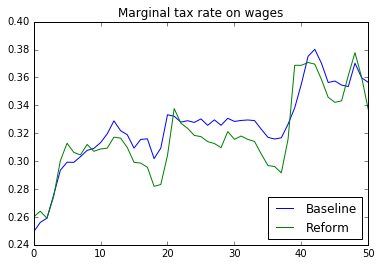

In [12]:
plot_evenly(calc_xx, calc_y1_beh, 'mtr')

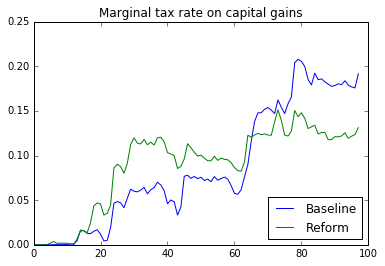

In [32]:
plot_evenly(calc_xx, calc_y1_beh, 'mtrcg')

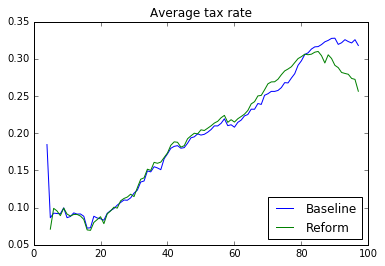

In [33]:
plot_evenly(calc_xx, calc_y1_beh, 'avgrate')

### Plot difference in MTRs on wages

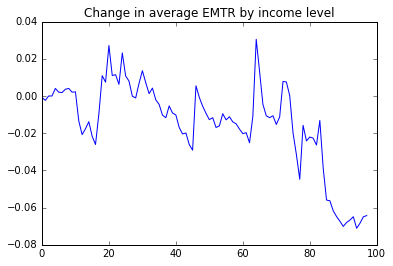

In [13]:
mtr_diff = group_evenly(calc_y1_beh)[1] - group_evenly(calc_xx)[1]
plt.plot(mtr_diff)
plt.title('Change in average EMTR by income level')

## Plot wage MTR charts for different demographics

#### Married with 2 kids (m2k), single with 1 kid (s1k), single with no kids (s0k)

In [13]:
def group_evenly_family(calc, family_type):
    assert family_type in ['m2k', 's1k', 's0k']
    mars = calc.records.MARS
    kids = calc.records.n24
    m2k_ind = [x for x in range(219814) if ((mars[x]==2) and (kids[x]==2))]
    s1k_ind = [x for x in range(219814) if ((mars[x]==4) and (kids[x]==1))][:8400]
    s0k_ind = [x for x in range(219814) if ((mars[x]==1) and (kids[x]==0))][:81472]
    
    if family_type == 'm2k':
        bins = 95
        size = 183
        use_ind = m2k_ind
    elif family_type == 's1k':
        bins = 48
        size = 175
        use_ind = s1k_ind
    else:
        bins = 67
        size = 271
        use_ind = s0k_ind
    
    mtr = getMTR(calc)[use_ind]
    agi = getAGI(calc)[use_ind]
    wgt = np.asarray(copy.deepcopy(calc.records.s006))[use_ind]
    
    all_together = zip(agi, mtr, wgt)
    all_together.sort()
    all_apart = zip(*all_together)
    agi_sorted = np.asarray(all_apart[0])
    mtr_sorted = np.asarray(all_apart[1])
    wgt_sorted = np.asarray(all_apart[2])
    
    agiList = [0] * bins
    mtrList = [0] * bins
    wgtList = [0] * bins
    
    for i in range(bins):
        agiList[i] = (agi_sorted[(i*size):((i+1)*size)] * wgt_sorted[(i*size):((i+1)*size)]).sum()
        mtrList[i] = (mtr_sorted[(i*size):((i+1)*size)] * wgt_sorted[(i*size):((i+1)*size)]).sum()
        wgtList[i] =  wgt_sorted[(i*size):((i+1)*size)].sum()
    
    
    agiFinal = np.asarray(agiList) / np.asarray(wgtList)
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    return agiFinal, mtrFinal
        
def plot_evenly_mtr_family(calc_baseline, calc_reform, family_type):
    baseline = group_evenly_family(calc_baseline, family_type)[1]
    reform = group_evenly_family(calc_reform, family_type)[1]
    plt.plot(baseline)
    plt.plot(reform)
    plt.legend(['Baseline', 'Reform'], loc='lower right')

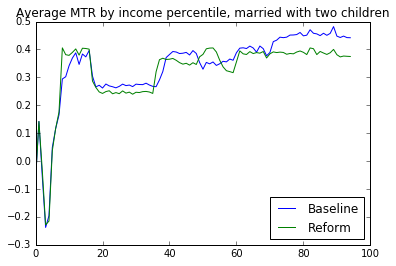

In [14]:
plot_evenly_mtr_family(calc_xx, calc_y1_beh, 'm2k')
plt.title('Average MTR by income percentile, married with two children')

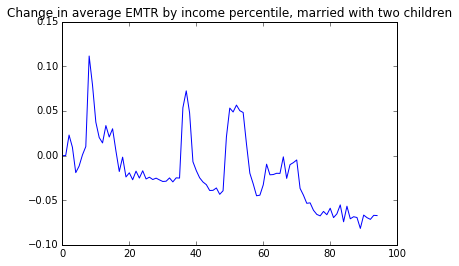

In [15]:
mtr_diff_m2k = group_evenly_family(calc_y1_beh, 'm2k')[1] - group_evenly_family(calc_xx, 'm2k')[1]
plt.plot(mtr_diff_m2k)
plt.title('Change in average EMTR by income percentile, married with two children')

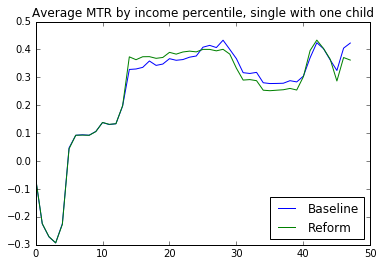

In [16]:
plot_evenly_mtr_family(calc_xx, calc_y1_beh, 's1k')
plt.title('Average MTR by income percentile, single with one child')

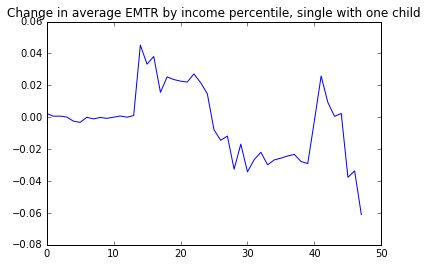

In [18]:
mtr_diff_s1k = group_evenly_family(calc_y1_beh, 's1k')[1] - group_evenly_family(calc_xx, 's1k')[1]
plt.plot(mtr_diff_s1k)
plt.title('Change in average EMTR by income percentile, single with one child')

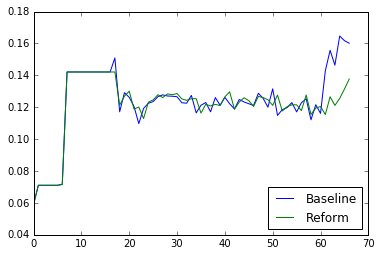

In [24]:
plot_evenly_mtr_family(calc_xx, calc_y1_beh, 's0k')
plt.title('Average MTR by income percentile, single with no children')

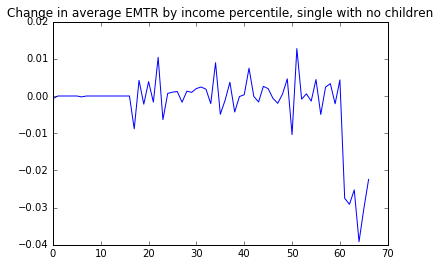

In [19]:
mtr_diff_s0k = group_evenly_family(calc_y1_beh, 's0k')[1] - group_evenly_family(calc_xx, 's0k')[1]
plt.plot(mtr_diff_s0k)
plt.title('Change in average EMTR by income percentile, single with no children')